# DSCI 552 HW6
### Name: Kehan Bi
### USC ID: 2608579504
### Date: November 17, 2021

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier


### 1. Supervised, Semi-Supervised, and Unsupervised Learning
### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set from: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+ %28Diagnostic%29. Download the data in https://archive.ics.uci.edu/ml/ machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.

In [2]:
wdbc = pd.read_csv("../data/wdbc.data", header = None)
wdbc.columns = ['ID', 'Diagnosis'] + ['feat' + str(i) for i in range(1,31)]
wdbc

,ID,Diagnosis,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
wdbc['Diagnosis'].value_counts()

B    357
M    212
Name: Diagnosis, dtype: int64

In [4]:
wdbc.replace({'B' : 0, 'M' : 1}, inplace=True)

In [5]:
#seperate dataset
def random_split(data, random_state):
    np.random.seed(random_state)
    idx, = np.where(data['Diagnosis'] == 0)
    num_test = round(len(idx) * 0.2)
    idx_test = np.random.choice(idx, num_test, replace = False)

    idx2, = np.where(data['Diagnosis'] == 1)
    num_test2 = round(len(idx2) * 0.2)
    idx_test2 = np.random.choice(idx2, num_test2, replace = False)

    final_test_idx = np.concatenate([idx_test, idx_test2])
    final_train_idx = np.array([i for i in range(data.shape[0]) if i not in final_test_idx])

    train_x = data.iloc[final_train_idx, 2:]
    train_y = data.iloc[final_train_idx, 1]
    test_x = data.iloc[final_test_idx, 2:]
    test_y = data.iloc[final_test_idx, 1]
    return train_x, train_y, test_x, test_y

In [6]:
train_x, train_y, test_x, test_y = random_split(wdbc, random_state = 1)

In [7]:
train_x

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,15.470,23.75,103.40,741.6,0.17910,0.52490,0.5355,0.1741,0.3985,0.12440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [8]:
train_y.value_counts()

0    286
1    170
Name: Diagnosis, dtype: int64

In [9]:
test_x

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30
459,9.755,28.20,61.68,290.9,0.07984,0.04626,0.01541,0.010430,0.1621,0.05952,...,10.670,36.92,68.03,349.9,0.1110,0.1109,0.07190,0.04866,0.2321,0.07211
409,12.270,17.92,78.41,466.1,0.08685,0.06526,0.03211,0.026530,0.1966,0.05597,...,14.100,28.88,89.00,610.2,0.1240,0.1795,0.13770,0.09532,0.3455,0.06896
539,7.691,25.44,48.34,170.4,0.08668,0.11990,0.09252,0.013640,0.2037,0.07751,...,8.678,31.89,54.49,223.6,0.1596,0.3064,0.33930,0.05000,0.2790,0.10660
313,11.540,10.72,73.73,409.1,0.08597,0.05969,0.01367,0.008907,0.1833,0.06100,...,12.340,12.87,81.23,467.8,0.1092,0.1626,0.08324,0.04715,0.3390,0.07434
524,9.847,15.68,63.00,293.2,0.09492,0.08419,0.02330,0.024160,0.1387,0.06891,...,11.240,22.99,74.32,376.5,0.1419,0.2243,0.08434,0.06528,0.2502,0.09209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,23.290,26.67,158.90,1685.0,0.11410,0.20840,0.35230,0.162000,0.2200,0.06229,...,25.120,32.68,177.00,1986.0,0.1536,0.4167,0.78920,0.27330,0.3198,0.08762
180,27.220,21.87,182.10,2250.0,0.10940,0.19140,0.28710,0.187800,0.1800,0.05770,...,33.120,32.85,220.80,3216.0,0.1472,0.4034,0.53400,0.26880,0.2856,0.08082
264,17.190,22.07,111.60,928.3,0.09726,0.08995,0.09061,0.065270,0.1867,0.05580,...,21.580,29.33,140.50,1436.0,0.1558,0.2567,0.38890,0.19840,0.3216,0.07570
17,16.130,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.102800,0.2164,0.07356,...,20.960,31.48,136.80,1315.0,0.1789,0.4233,0.47840,0.20730,0.3706,0.11420


In [10]:
test_y.value_counts()

0    71
1    42
Name: Diagnosis, dtype: int64

### (b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.
### i. Supervised Learning: Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [11]:
average_summary = {}

In [12]:
def summary(train_data, predict, prob, report, title):
    cm = confusion_matrix(train_data, predict)
    print("The confusion matrix of {} data is \n{}".format(title, cm))
    acc = report['accuracy']
    print("The classification accuracy is {}".format(acc))
    fpr, tpr, thresholds = roc_curve(train_data, prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of {} data'.format(title))
    plt.legend()
    plt.show()

Report the model summary of total 30 runs of Supervised Learning Monte-Carlo Simulation:
The confusion matrix of train data is 
[[285   1]
 [  4 166]]
The classification accuracy is 0.9890350877192983


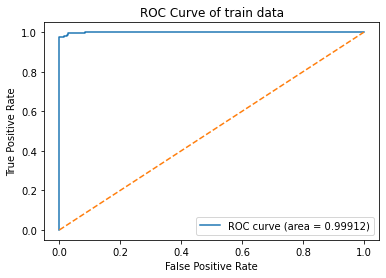

The confusion matrix of test data is 
[[69  2]
 [ 4 38]]
The classification accuracy is 0.9469026548672567


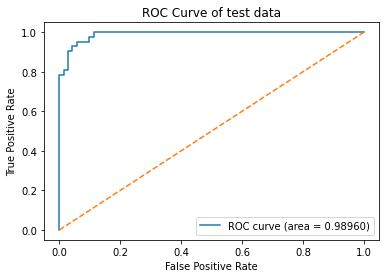


The average score for both training and test sets over total 30 runs:
            accuracy  precision    recall  f1_score       auc
train data  0.989035   0.989087  0.989035  0.989015  0.999116
test data   0.946903   0.946988  0.946903  0.946624  0.989604


In [13]:
for i in range(30):
    # split data
    train_x, train_y, test_x, test_y = random_split(wdbc, random_state = i)
    # Normalize data
    scaler = Normalizer()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)
    
    param_grid = {'C' : np.logspace(-4, 4, 9)}
    cv = StratifiedKFold(5, random_state = i, shuffle = True)    
    clf = GridSearchCV(estimator = LinearSVC(penalty='l1', dual=False), param_grid = param_grid, 
    cv = cv, n_jobs = -1, scoring = 'f1_weighted', verbose = 0)
    clf.fit(train_x, train_y)
    
    # predict and evaluate the model
    # train data
    train_y_pred_prob = clf.decision_function(train_x)
    train_y_pred = clf.predict(train_x)
    train_report = classification_report(train_y, train_y_pred, output_dict=True)

    fpr, tpr, thresholds = roc_curve(train_y, train_y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    metrics = {'accuracy' : train_report['accuracy'], 'precision' : train_report['weighted avg']['precision'], 
    'recall' : train_report['weighted avg']['recall'], 'f1_score' : train_report['weighted avg']['f1-score'], 
    'auc' : roc_auc}

    train_score = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    train_score = train_score.append(metrics, ignore_index=True)
    
    # test data
    test_y_pred_prob = clf.decision_function(test_x)
    test_y_pred = clf.predict(test_x)
    test_report = classification_report(test_y, test_y_pred, output_dict=True)

    fpr, tpr, thresholds = roc_curve(test_y, test_y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    metrics_test = {'accuracy' : test_report['accuracy'], 'precision' : test_report['weighted avg']['precision'], 
    'recall' : test_report['weighted avg']['recall'], 'f1_score' : test_report['weighted avg']['f1-score'], 
    'auc' : roc_auc}
    test_score = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    test_score = test_score.append(metrics_test, ignore_index=True)

print('Report the model summary of total 30 runs of Supervised Learning Monte-Carlo Simulation:')
summary(train_y, train_y_pred, train_y_pred_prob, train_report, 'train')
summary(test_y, test_y_pred, test_y_pred_prob, test_report, 'test')

# average metrics
print('\nThe average score for both training and test sets over total 30 runs:')
train_score = train_score.apply(lambda x: x.mean(), axis=0)
test_score = test_score.apply(lambda x: x.mean(), axis=0)
average = pd.concat([train_score, test_score], axis=1)
average = average.T.set_index(pd.Series(['train data', 'test data']))
average_summary['Supervised Learning'] = average
print(average)

### ii. Semi-Supervised Learning/ Self-training: select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.
### A. Train an L1-penalized SVM to classify the labeled data Use normalized data. Choose the penalty parameter using 5 fold cross validation.
### B. Findtheunlabeleddatapointthatisthefarthesttothedecisionboundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [14]:
def semi_sup_svm(train_x, train_y):
    labeled_idx = []
    for c in [0, 1]:
        c_idx, = np.where(train_y == c)
        idx_num = round(len(c_idx) * 0.5)
        sel_idx = np.random.choice(c_idx, idx_num, replace=False)
        labeled_idx.extend(sel_idx)
    
    unlabeled_idx = [i for i in range(len(train_x)) if i not in labeled_idx]
    labeled_x = train_x[labeled_idx].tolist()
    labeled_y = train_y.iloc[labeled_idx].tolist()
    unlabeled_x = train_x[unlabeled_idx].tolist()
    unlabeled_y = train_y.iloc[unlabeled_idx].to_numpy().tolist()

    param_grid = {'C' : np.logspace(-4, 4, 9)}
    cv = StratifiedKFold(5, random_state = i, shuffle = True)
    clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), param_grid = param_grid, 
    cv = cv, scoring = 'f1_weighted', n_jobs = -1, verbose = 0)
    clf.fit(labeled_x, labeled_y)
    
    while len(unlabeled_x) > 0:
        scores = clf.decision_function(unlabeled_x)
        sorted_idx = sorted([i for i in range(len(unlabeled_x))], 
                            key=lambda x : abs(scores[x]))
        unlabeled_x = [unlabeled_x[i] for i in sorted_idx]
        unlabeled_y = [unlabeled_y[i] for i in sorted_idx]
        labeled_x.append(unlabeled_x.pop())
        labeled_y.append(unlabeled_y.pop())
        clf.best_estimator_.fit(labeled_x, labeled_y)
    return clf


Report the model summary of total 30 runs of Semi-Supervised Learning Monte-Carlo Simulation:
The confusion matrix of train data is 
[[285   1]
 [  4 166]]
The classification accuracy is 0.9890350877192983


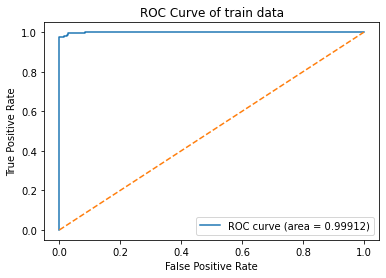

The confusion matrix of test data is 
[[69  2]
 [ 4 38]]
The classification accuracy is 0.9469026548672567


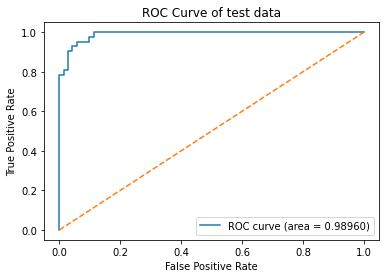


The average score for both training and test sets over total 30 runs:
            accuracy  precision    recall  f1_score       auc
train data  0.989035   0.989087  0.989035  0.989015  0.999116
test data   0.946903   0.946988  0.946903  0.946624  0.989604


In [15]:
for i in range(30):
    # split data
    train_x, train_y, test_x, test_y = random_split(wdbc, random_state = i)
    # Normalize data
    scaler = Normalizer()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)

    clf = semi_sup_svm(train_x, train_y)
    # train data
    train_y_pred_prob = clf.decision_function(train_x)
    train_y_pred = clf.predict(train_x)
    train_report = classification_report(train_y, train_y_pred, output_dict=True)

    fpr, tpr, thresholds = roc_curve(train_y, train_y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    metrics = {'accuracy' : train_report['accuracy'], 'precision' : train_report['weighted avg']['precision'], 
    'recall' : train_report['weighted avg']['recall'], 'f1_score' : train_report['weighted avg']['f1-score'], 
    'auc' : roc_auc}

    train_score = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    train_score = train_score.append(metrics, ignore_index=True)
    
    # test data
    test_y_pred_prob = clf.decision_function(test_x)
    test_y_pred = clf.predict(test_x)
    test_report = classification_report(test_y, test_y_pred, output_dict=True)

    fpr, tpr, thresholds = roc_curve(test_y, test_y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    metrics_test = {'accuracy' : test_report['accuracy'], 'precision' : test_report['weighted avg']['precision'], 
    'recall' : test_report['weighted avg']['recall'], 'f1_score' : test_report['weighted avg']['f1-score'], 
    'auc' : roc_auc}
    test_score = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    test_score = test_score.append(metrics_test, ignore_index=True)
    
print('Report the model summary of total 30 runs of Semi-Supervised Learning Monte-Carlo Simulation:')
summary(train_y, train_y_pred, train_y_pred_prob, train_report, 'train')
summary(test_y, test_y_pred, test_y_pred_prob, test_report, 'test')

# average metrics
print('\nThe average score for both training and test sets over total 30 runs:')
train_score = train_score.apply(lambda x: x.mean(), axis=0)
test_score = test_score.apply(lambda x: x.mean(), axis=0)
average = pd.concat([train_score, test_score], axis=1)
average = average.T.set_index(pd.Series(['train data', 'test data']))
average_summary['Semi-Supervised Learning'] = average
print(average)

### iii. Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.
### A. Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?
### B. Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.  
### C. Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

Report the model summary of total 30 runs of Unsupervised Learning Monte-Carlo Simulation:
The confusion matrix of train data is 
[[282   4]
 [ 45 125]]
The classification accuracy is 0.8925438596491229


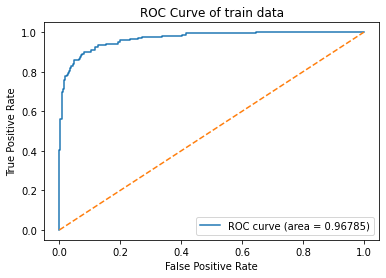

The confusion matrix of test data is 
[[70  1]
 [17 25]]
The classification accuracy is 0.8407079646017699


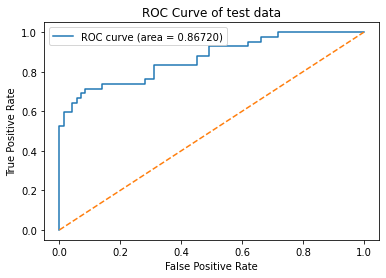


The average score for both training and test sets over total 30 runs:
            accuracy  precision    recall  f1_score       auc
train data  0.892544   0.902129  0.892544  0.888770  0.967853
test data   0.840708   0.862930  0.840708  0.830033  0.867203


In [16]:
for i in range(30):
    # split data
    train_x, train_y, test_x, test_y = random_split(wdbc, random_state = i)
    # Normalize data
    scaler = Normalizer()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)

    clusterer = KMeans(n_clusters=2, n_init = 15, random_state = i).fit(train_x)
    
    # predict and evaluate the model
    # train data
    train_label = clusterer.predict(train_x)
    # get distance
    dist = np.ndarray((train_x.shape[0],))
    train_y_pred_prob = np.ndarray((train_x.shape[0], 2))
    centers = clusterer.cluster_centers_
    for i, x in enumerate(train_x):
        center = centers[train_label[i]]
        dist[i] = np.linalg.norm(x - center)
        train_y_pred_prob[i, 0] = np.linalg.norm(x - centers[0])
        train_y_pred_prob[i, 1] = np.linalg.norm(x - centers[1])
    train_y_pred_prob = softmax(train_y_pred_prob, axis=1).astype(np.float64)

    # get majority
    cluster_lable = np.ndarray((2,), dtype='int')
    train_y_pred = train_label.copy()
    for c in [0, 1]:
        sample_idx, = np.where(train_label == c)
        top30 = sorted(sample_idx.tolist(), key=lambda i : dist[i])[:30]
        majority = train_y.iloc[top30].value_counts().index[0]
        train_y_pred[sample_idx] = majority
        cluster_lable[majority] = c
    
    pos_cluster = cluster_lable[0]
    train_y_pred_prob = train_y_pred_prob[:, pos_cluster]
    train_report = classification_report(train_y, train_y_pred, output_dict=True)

    fpr, tpr, thresholds = roc_curve(train_y, train_y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    metrics = {'accuracy' : train_report['accuracy'], 'precision' : train_report['weighted avg']['precision'], 
    'recall' : train_report['weighted avg']['recall'], 'f1_score' : train_report['weighted avg']['f1-score'], 
    'auc' : roc_auc}

    train_score = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    train_score = train_score.append(metrics, ignore_index=True)
    
    # test data
    test_label = clusterer.predict(test_x)
    # get distance
    dist = np.ndarray((test_x.shape[0],))
    test_y_pred_prob = np.ndarray((test_x.shape[0], 2))
    centers = clusterer.cluster_centers_
    for i, x in enumerate(test_x):
        center = centers[test_label[i]]
        dist[i] = np.linalg.norm(x - center)
        test_y_pred_prob[i, 0] = np.linalg.norm(x - centers[0])
        test_y_pred_prob[i, 1] = np.linalg.norm(x - centers[1])
    test_y_pred_prob = softmax(test_y_pred_prob, axis=1).astype(np.float64)

    # get majority
    cluster_lable = np.ndarray((2,), dtype='int')
    test_y_pred = test_label.copy()
    for c in [0, 1]:
        sample_idx, = np.where(test_label == c)
        top30 = sorted(sample_idx.tolist(), key=lambda i : dist[i])[:30]
        majority = test_y.iloc[top30].value_counts().index[0]
        test_y_pred[sample_idx] = majority
        cluster_lable[majority] = c

    pos_cluster = cluster_lable[0]
    test_y_pred_prob = test_y_pred_prob[:, pos_cluster]
    test_report = classification_report(test_y, test_y_pred, output_dict=True)

    fpr, tpr, thresholds = roc_curve(test_y, test_y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    metrics_test = {'accuracy' : test_report['accuracy'], 'precision' : test_report['weighted avg']['precision'], 
    'recall' : test_report['weighted avg']['recall'], 'f1_score' : test_report['weighted avg']['f1-score'], 
    'auc' : roc_auc}
    test_score = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    test_score = test_score.append(metrics_test, ignore_index=True)
    
print('Report the model summary of total 30 runs of Unsupervised Learning Monte-Carlo Simulation:')
summary(train_y, train_y_pred, train_y_pred_prob, train_report, 'train')
summary(test_y, test_y_pred, test_y_pred_prob, test_report, 'test')

# average metrics
print('\nThe average score for both training and test sets over total 30 runs:')
train_score = train_score.apply(lambda x: x.mean(), axis=0)
test_score = test_score.apply(lambda x: x.mean(), axis=0)
average = pd.concat([train_score, test_score], axis=1)
average = average.T.set_index(pd.Series(['train data', 'test data']))
average_summary['Unsupervised Learning'] = average
print(average)

### iv. Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clus- tering based on kernels.3 Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method.

Report the model summary of total 30 runs of Spectral Clustering Monte-Carlo Simulation:
The confusion matrix of train data is 
[[282   4]
 [ 45 125]]
The classification accuracy is 0.8925438596491229


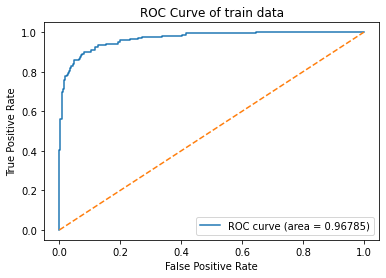

The confusion matrix of test data is 
[[69  2]
 [18 24]]
The classification accuracy is 0.8230088495575221


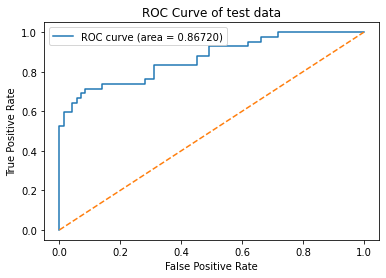


The average score for both training and test sets over total 30 runs:
            accuracy  precision    recall  f1_score       auc
train data  0.892544   0.902129  0.892544  0.888770  0.967853
test data   0.823009   0.841412  0.823009  0.811148  0.867203


In [17]:
for i in range(30):
    # split data
    train_x, train_y, test_x, test_y = random_split(wdbc, random_state = i)
    # Normalize data
    scaler = Normalizer()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)

    label = SpectralClustering(n_clusters=2, assign_labels='kmeans', affinity='rbf', eigen_tol = 1e-2, 
    eigen_solver = 'arpack', random_state=1)
    label = label.fit_predict(train_x)
    cluster_centers = []
    for c in [0,1]:
        cluster_centers.append(np.mean(train_x[label == c], axis = 0).tolist())
    
    # KNN classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_x, label)
    train_label = knn.predict(train_x)

    # get distance
    dist = np.ndarray((train_x.shape[0],))
    train_y_pred_prob = np.ndarray((train_x.shape[0], 2))
    for i, x in enumerate(train_x):
        center = cluster_centers[train_label[i]]
        dist[i] = np.linalg.norm(x - center)
        train_y_pred_prob[i, 0] = np.linalg.norm(x - cluster_centers[0])
        train_y_pred_prob[i, 1] = np.linalg.norm(x - cluster_centers[1])
    train_y_pred_prob = softmax(train_y_pred_prob, axis=1).astype(np.float64)

    # get majority
    cluster_lable = np.ndarray((2,), dtype='int')
    train_y_pred = train_label.copy()
    for c in [0, 1]:
        sample_idx, = np.where(train_label == c)
        top30 = sorted(sample_idx.tolist(), key=lambda i : dist[i])[:30]
        majority = train_y.iloc[top30].value_counts().index[0]
        train_y_pred[sample_idx] = majority
        cluster_lable[majority] = c
    
    pos_cluster = cluster_lable[0]
    train_y_pred_prob = train_y_pred_prob[:, pos_cluster]
    train_report = classification_report(train_y, train_y_pred, output_dict=True)

    fpr, tpr, thresholds = roc_curve(train_y, train_y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    metrics = {'accuracy' : train_report['accuracy'], 'precision' : train_report['weighted avg']['precision'], 
    'recall' : train_report['weighted avg']['recall'], 'f1_score' : train_report['weighted avg']['f1-score'], 
    'auc' : roc_auc}

    train_score = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    train_score = train_score.append(metrics, ignore_index=True)
    
    # test data
    test_label = knn.predict(test_x)
    # get distance
    dist = np.ndarray((test_x.shape[0],))
    test_y_pred_prob = np.ndarray((test_x.shape[0], 2))
    for i, x in enumerate(test_x):
        center = cluster_centers[test_label[i]]
        dist[i] = np.linalg.norm(x - center)
        test_y_pred_prob[i, 0] = np.linalg.norm(x - cluster_centers[0])
        test_y_pred_prob[i, 1] = np.linalg.norm(x - cluster_centers[1])
    test_y_pred_prob = softmax(test_y_pred_prob, axis=1).astype(np.float64)

    # get majority
    cluster_lable = np.ndarray((2,), dtype='int')
    test_y_pred = test_label.copy()
    for c in [0, 1]:
        sample_idx, = np.where(test_label == c)
        top30 = sorted(sample_idx.tolist(), key=lambda i : dist[i])[:30]
        majority = test_y.iloc[top30].value_counts().index[0]
        test_y_pred[sample_idx] = majority
        cluster_lable[majority] = c

    pos_cluster = cluster_lable[0]
    test_y_pred_prob = test_y_pred_prob[:, pos_cluster]
    test_report = classification_report(test_y, test_y_pred, output_dict=True)

    fpr, tpr, thresholds = roc_curve(test_y, test_y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    metrics_test = {'accuracy' : test_report['accuracy'], 'precision' : test_report['weighted avg']['precision'], 
    'recall' : test_report['weighted avg']['recall'], 'f1_score' : test_report['weighted avg']['f1-score'], 
    'auc' : roc_auc}
    test_score = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    test_score = test_score.append(metrics_test, ignore_index=True)
    
print('Report the model summary of total 30 runs of Spectral Clustering Monte-Carlo Simulation:')
summary(train_y, train_y_pred, train_y_pred_prob, train_report, 'train')
summary(test_y, test_y_pred, test_y_pred_prob, test_report, 'test')

# average metrics
print('\nThe average score for both training and test sets over total 30 runs:')
train_score = train_score.apply(lambda x: x.mean(), axis=0)
test_score = test_score.apply(lambda x: x.mean(), axis=0)
average = pd.concat([train_score, test_score], axis=1)
average = average.T.set_index(pd.Series(['train data', 'test data']))
average_summary['Spectral Clustering'] = average
print(average)

### v. One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.


In [18]:
for k in average_summary.keys():
    print(k, ":")
    print(average_summary[k])

Supervised Learning :
            accuracy  precision    recall  f1_score       auc
train data  0.989035   0.989087  0.989035  0.989015  0.999116
test data   0.946903   0.946988  0.946903  0.946624  0.989604
Semi-Supervised Learning :
            accuracy  precision    recall  f1_score       auc
train data  0.989035   0.989087  0.989035  0.989015  0.999116
test data   0.946903   0.946988  0.946903  0.946624  0.989604
Unsupervised Learning :
            accuracy  precision    recall  f1_score       auc
train data  0.892544   0.902129  0.892544  0.888770  0.967853
test data   0.840708   0.862930  0.840708  0.830033  0.867203
Spectral Clustering :
            accuracy  precision    recall  f1_score       auc
train data  0.892544   0.902129  0.892544  0.888770  0.967853
test data   0.823009   0.841412  0.823009  0.811148  0.867203


**We can found a result from the summary above that the performance comparison: supervised > semi-simpervised > unsupervised.**

### 2. Active Learning Using Support Vector Machines
### (a) Download the banknote authentication Data Set from: https://archive.ics. uci.edu/ml/datasets/banknote+authentication. Choose 472 data points ran- domly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [19]:
banknote = pd.read_csv('../data/data_banknote_authentication.txt', header = None)
banknote.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

In [20]:
test_index = np.random.choice(banknote.shape[0], 472, replace=False)
train_index = np.array([i for i in range(banknote.shape[0]) if i not in test_index])
banknote_train = banknote.iloc[train_index]
banknote_test = banknote.iloc[test_index]
banknote_train

,variance,skewness,curtosis,entropy,class
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
5,4.36840,9.67180,-3.9606,-3.16250,0
7,2.09220,-6.81000,8.4636,-0.60216,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [21]:
train_x = banknote_train.iloc[:, :-1]
train_y = banknote_train.iloc[:, -1]
test_x = banknote_test.iloc[:, :-1]
test_y = banknote_test.iloc[:, -1]
train_x

,variance,skewness,curtosis,entropy
2,3.86600,-2.63830,1.9242,0.10645
3,3.45660,9.52280,-4.0112,-3.59440
4,0.32924,-4.45520,4.5718,-0.98880
5,4.36840,9.67180,-3.9606,-3.16250
7,2.09220,-6.81000,8.4636,-0.60216
...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949
1368,-1.38870,-4.87730,6.4774,0.34179
1369,-3.75030,-13.45860,17.5932,-2.77710
1370,-3.56370,-8.38270,12.3930,-1.28230


### (b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.
### i. TrainaSVMwithapoolof10randomlyselecteddatapointsfromthetraining set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation.4 Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.

In [22]:
learning_curve = []
for i in range(50):
    total_index = np.arange(train_x.shape[0])
    used = []
    acc_list = []
    
    while len(total_index) > 0:
        np.random.shuffle(total_index)
        pool = total_index[:10]
        total_index = total_index[10:]
        used.extend(pool)

        used_train_x = train_x.iloc[used]
        used_train_y = train_y.iloc[used]
        
        param_grid = {'C' : np.logspace(-4, 4, 10)}
        cv = StratifiedKFold(5, random_state = i, shuffle=True)
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), param_grid = param_grid, cv = cv, 
        scoring = 'f1_weighted', n_jobs = -1, verbose = 0 )
        clf.fit(used_train_x, used_train_y)

        test_y_pred = clf.predict(test_x)
        test_report = classification_report(test_y, test_y_pred, output_dict=True)
        acc_list.append(test_report['accuracy'])
    learning_curve.append(acc_list)

learning_curve = np.array(learning_curve)
learning_curve = np.mean(learning_curve, axis=0)
passive = learning_curve

### ii. TrainaSVMwithapoolof10randomlyselecteddatapointsfromthetraining set5 using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

In [23]:
learning_curve = []
for i in range(50):
    total_index = np.arange(train_x.shape[0])
    used = []
    acc_list = []
    
    np.random.shuffle(total_index)
    pool = total_index[:10]
    total_index = total_index[10:]
    used.extend(pool)
    
    while len(used) <= 900:
        used_train_x = train_x.iloc[used]
        used_train_y = train_y.iloc[used]
        
        cv = StratifiedKFold(5, random_state = i, shuffle=True)
        param_grid = {'C' : np.logspace(-4, 4, 10)}
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), param_grid = param_grid, cv = cv, 
        scoring = 'f1_weighted', n_jobs = -1, verbose = 0)
        clf.fit(used_train_x, used_train_y)
        
        # evaluate on test
        test_y_pred = clf.predict(test_x)
        test_report = classification_report(test_y, test_y_pred, output_dict=True)
        acc_list.append(test_report['accuracy'])
        
        if len(total_index) == 0:
            break
        
        dist = clf.decision_function(train_x.iloc[total_index])
        sortedarg = np.arange(len(total_index))
        sorted(sortedarg, key=lambda i : abs(dist[i]))
        total_index = total_index[sortedarg]
        pool = total_index[:10]
        total_index = total_index[10:]
        used.extend(pool)

    learning_curve.append(acc_list)
learning_curve = np.array(learning_curve)
learning_curve = np.mean(learning_curve, axis=0)
active = learning_curve

### (c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

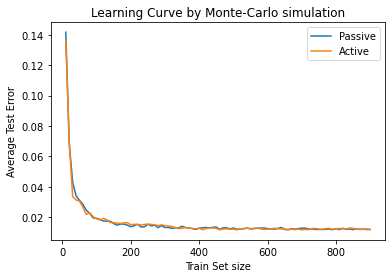

In [24]:
x = 10 * np.arange(1, 91)
plt.figure()
plt.plot(x, 1 - passive, label='Passive')
plt.plot(x, 1 - active, label='Active')
plt.xlabel("Train Set size")
plt.ylabel("Average Test Error")
plt.title("Learning Curve by Monte-Carlo simulation")
plt.legend()
plt.show()